In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.metrics.pairwise import haversine_distances

from catboost import CatBoostRegressor, Pool

pd.set_option('display.max_rows', 100)

In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df.drop_duplicates(inplace=True)
test_df = pd.read_csv('./data/test.csv')
test_df.drop_duplicates(inplace=True)
print(f'Number of rows in training data: {train_df.shape[0]}')
print(f'Number of rows in test data: {test_df.shape[0]}')
train_df.head()

Number of rows in training data: 59727
Number of rows in test data: 29045


,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


# Distance to good schools

In [3]:
school_df = pd.read_csv('./data/auxiliary-data/sg-primary-schools-processed.csv')
school_df.rename(columns={'name': 'School'}, inplace=True)

# convert latitudes and longitudes to radians
school_df['lat_rads'] = np.radians(school_df['latitude'])
school_df['long_rads'] = np.radians(school_df['longitude'])

school_df.head()

,School,latitude,longitude,lat_rads,long_rads
0,Admiralty,1.454038,103.817436,0.025378,1.811956
1,Ahmad Ibrahim,1.433153,103.832942,0.025013,1.812227
2,Ai Tong,1.360583,103.833020,0.023747,1.812228
3,Alexandra,1.291334,103.824425,0.022538,1.812078
4,Anchor Green,1.390370,103.887165,0.024267,1.813173


In [4]:
ballot_df = pd.read_csv('./data/auxiliary-data/sg-school-balloting-processed.csv')
ballot_df.head()

,School,Phase 1,2A,2B,2C
0,Admiralty,0.500000,0.426667,1.088235,1.557143
1,Ahmad Ibrahim,0.337500,0.094340,0.000000,0.171975
2,Ai Tong,0.475000,0.952381,2.545455,1.733333
3,Alexandra,0.407143,0.156627,0.093023,1.110236
4,Anchor Green,0.472222,0.315789,0.000000,0.281250


In [5]:
school_df = school_df.merge(ballot_df, on='School', how='left')
school_df.head()

,School,latitude,longitude,lat_rads,long_rads,Phase 1,2A,2B,2C
0,Admiralty,1.454038,103.817436,0.025378,1.811956,0.500000,0.426667,1.088235,1.557143
1,Ahmad Ibrahim,1.433153,103.832942,0.025013,1.812227,0.337500,0.094340,0.000000,0.171975
2,Ai Tong,1.360583,103.833020,0.023747,1.812228,0.475000,0.952381,2.545455,1.733333
3,Alexandra,1.291334,103.824425,0.022538,1.812078,0.407143,0.156627,0.093023,1.110236
4,Anchor Green,1.390370,103.887165,0.024267,1.813173,0.472222,0.315789,0.000000,0.281250


In [6]:
school_df[school_df.isna().any(axis=1)] = school_df[school_df.isna().any(axis=1)].fillna(0)
school_df.isna().sum()

School       0
latitude     0
longitude    0
lat_rads     0
long_rads    0
Phase 1      0
2A           0
2B           0
2C           0
dtype: int64

In [7]:
school_df.describe()

,latitude,longitude,lat_rads,long_rads,Phase 1,2A,2B,2C
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.363017,103.842126,0.023789,1.812387,0.441880,0.524625,0.447522,1.002233
std,0.042669,0.071838,0.000745,0.001254,0.152676,0.460166,0.674936,0.896141
min,1.274958,103.687770,0.022252,1.809693,0.000000,0.000000,0.000000,0.000000
25%,1.334762,103.786035,0.023296,1.811408,0.337500,0.183099,0.000000,0.350000
50%,1.357651,103.845523,0.023695,1.812446,0.463636,0.385965,0.062500,0.781250
75%,1.390302,103.899078,0.024265,1.813381,0.550000,0.781609,0.687500,1.389831
max,1.456608,103.961677,0.025423,1.814474,0.800000,3.543478,3.400000,5.895833


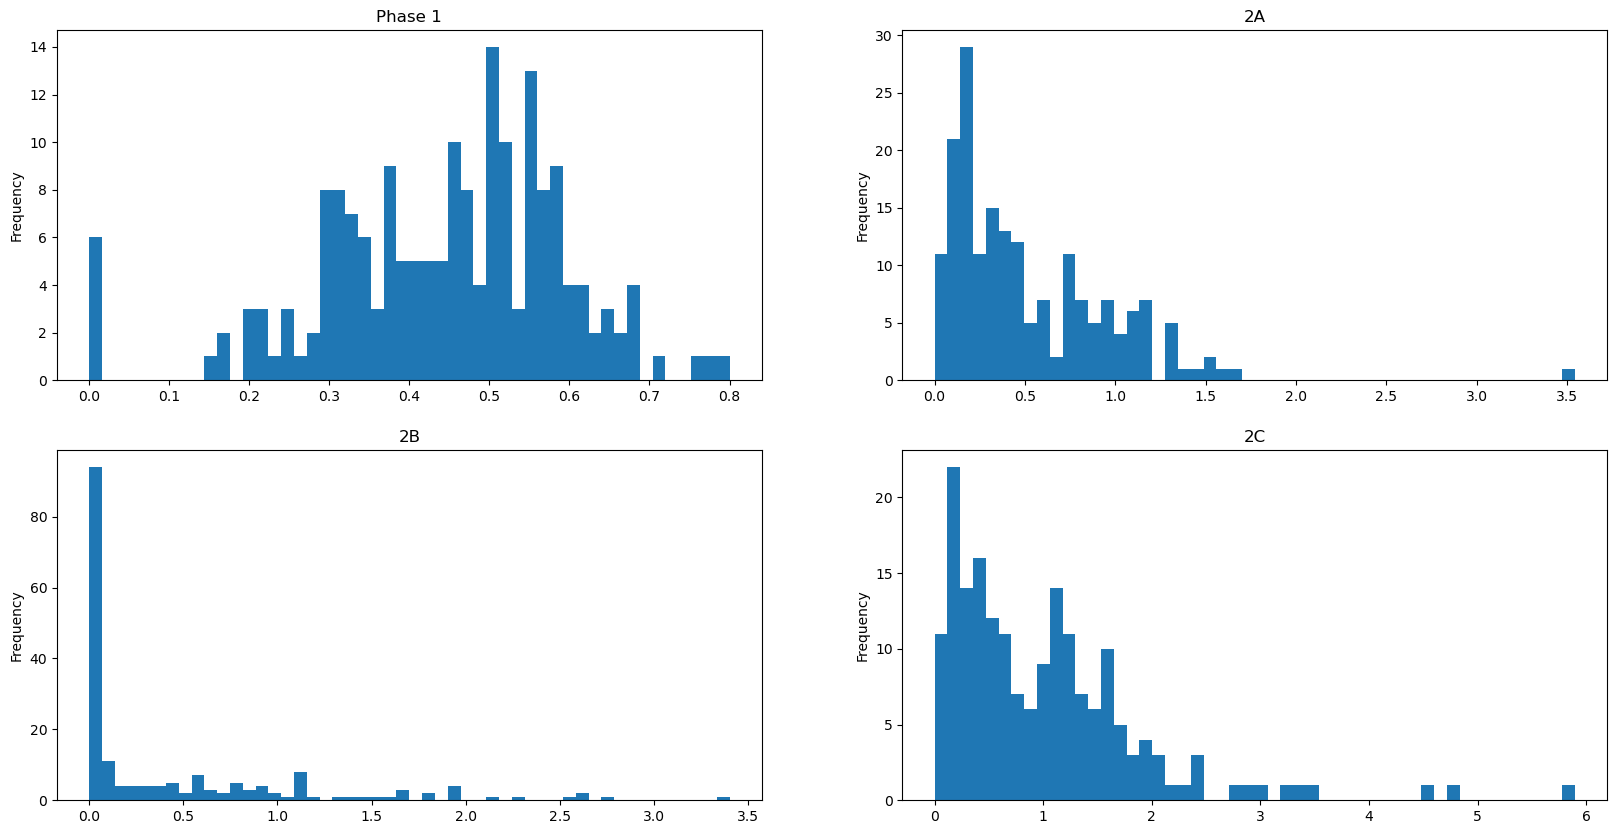

In [8]:
# Example distribution of subscription ratios
cols = school_df.columns[5:]
n = len(cols) // 2
fig,ax = plt.subplots(2, n, figsize=(20, 10))
for i, col in enumerate(cols):
    school_df[col].plot(ax=ax[i//n, i%n], kind='hist', bins=50)
    ax[i//n, i%n].set_title(col)

In [9]:
# set thresholds for each category
top_threshold = 1.8
good_threshold = 1.0
sch_cats = {}

In [10]:
# use phase 2B and 2C subscription ratios to categorise schools
sch_cats['top'] = school_df[(school_df['2B'] >= top_threshold) | (school_df['2C'] >= top_threshold)]
print(len(sch_cats['top']))
sch_cats['top']

31


,School,latitude,longitude,lat_rads,long_rads,Phase 1,2A,2B,2C
2,Ai Tong,1.360583,103.833020,0.023747,1.812228,0.475000,0.952381,2.545455,1.733333
7,Anglo-Chinese,1.318371,103.835610,0.023010,1.812273,0.311111,0.854839,1.961538,1.283019
15,Bukit Panjang,1.373622,103.769375,0.023974,1.811117,0.555556,0.975000,1.142857,2.119048
30,CHIJ (Toa Payoh),1.332753,103.841847,0.023261,1.812382,0.340000,0.780000,1.962963,1.254545
31,CHIJ St. Nicholas Girls,1.373979,103.834240,0.023980,1.812249,0.466667,1.287500,2.300000,2.100000
51,Fairfield Methodist,1.301004,103.785456,0.022707,1.811398,0.552381,1.095745,2.600000,1.650000
61,Gongshang,1.357116,103.949145,0.023686,1.814255,0.712500,3.543478,0.800000,2.431818
66,Holy Innocents,1.366938,103.894115,0.023858,1.813294,0.509524,1.116505,2.650000,2.875000
68,Hong Wen,1.321760,103.857628,0.023069,1.812658,0.546667,0.492754,0.937500,2.188406
69,Horizon,1.399550,103.913405,0.024427,1.813631,0.572222,1.363636,0.800000,1.840909


In [11]:
sch_cats['good'] = school_df[((school_df['2B'] < top_threshold) & (school_df['2C'] < top_threshold)) & ((school_df['2B'] >= good_threshold) | (school_df['2C'] >= good_threshold))]
print(len(sch_cats['good']))
sch_cats['good']

53


,School,latitude,longitude,lat_rads,long_rads,Phase 1,2A,2B,2C
0,Admiralty,1.454038,103.817436,0.025378,1.811956,0.500000,0.426667,1.088235,1.557143
3,Alexandra,1.291334,103.824425,0.022538,1.812078,0.407143,0.156627,0.093023,1.110236
5,Anderson,1.384264,103.841392,0.024160,1.812374,0.473333,0.582278,0.612903,1.243243
6,Anglo-Chinese (Junior),1.309350,103.840950,0.022852,1.812366,0.361905,0.753731,1.677419,1.274194
8,Angsana,1.348553,103.951808,0.023537,1.814301,0.400000,0.719697,0.062500,1.757895
18,Canberra,1.451250,103.815859,0.025329,1.811929,0.444444,0.160000,0.458333,1.073770
19,Canossa Catholic,1.326644,103.882228,0.023154,1.813087,0.800000,0.250000,0.826087,1.120000
22,Catholic High,1.354389,103.844211,0.023639,1.812423,0.355556,1.163793,1.450000,1.300000
28,CHIJ Our Lady of the Nativity,1.373574,103.897769,0.023973,1.813358,0.333333,0.200000,0.865385,1.018018
32,Chongfu,1.438396,103.839309,0.025105,1.812338,0.508333,0.618644,1.514286,1.555556


In [12]:
sch_cats['normal'] = school_df[(school_df['2B'] < good_threshold) & (school_df['2C'] < good_threshold)]
print(len(sch_cats['normal']))
sch_cats['normal']

101


,School,latitude,longitude,lat_rads,long_rads,Phase 1,2A,2B,2C
1,Ahmad Ibrahim,1.433153,103.832942,0.025013,1.812227,0.337500,0.094340,0.000000,0.171975
4,Anchor Green,1.390370,103.887165,0.024267,1.813173,0.472222,0.315789,0.000000,0.281250
9,Ang Mo Kio,1.365588,103.850957,0.023834,1.812541,0.355556,0.568966,0.000000,0.341176
10,Beacon,1.383949,103.773632,0.024154,1.811192,0.666667,0.200000,0.000000,0.369048
11,Bedok Green,1.323446,103.937879,0.023098,1.814058,0.380000,0.117021,0.000000,0.188811
...,...,...,...,...,...,...,...,...,...
180,Yuhua,1.342802,103.741106,0.023436,1.810624,0.316667,0.186992,0.018868,0.143750
181,Yumin,1.351292,103.950462,0.023584,1.814278,0.293750,0.106195,0.000000,0.086957
182,Zhangde,1.284212,103.825952,0.022414,1.812105,0.525000,0.385965,0.000000,0.926316
183,Zhenghua,1.379549,103.769314,0.024078,1.811116,0.520000,0.763889,0.076923,0.578947


In [13]:
# map latitudes and longitudes to radians
train_df['lat_rads'] = np.radians(train_df['latitude'])
train_df['long_rads'] = np.radians(train_df['longitude'])
test_df['lat_rads'] = np.radians(test_df['latitude'])
test_df['long_rads'] = np.radians(test_df['longitude'])
for key in sch_cats.keys():
    distance = haversine_distances(train_df[['lat_rads', 'long_rads']], sch_cats[key][['lat_rads', 'long_rads']])
    distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
    train_df[f'num_{key}_sch_1km'] = (distance < 1).sum(axis=1)
    train_df[f'num_{key}_sch_2km'] = (distance < 2).sum(axis=1)
    distance = haversine_distances(test_df[['lat_rads', 'long_rads']], sch_cats[key][['lat_rads', 'long_rads']])
    distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
    test_df[f'num_{key}_sch_1km'] = (distance < 1).sum(axis=1)
    test_df[f'num_{key}_sch_2km'] = (distance < 2).sum(axis=1)
train_df

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,region,monthly_rent,lat_rads,long_rads,num_top_sch_1km,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,...,west region,1600,0.023466,1.810581,1,1,0,2,2,4
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,...,east region,2250,0.023216,1.814073,1,2,1,1,3,6
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,...,central region,1900,0.023252,1.812448,1,4,0,1,1,3
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,...,east region,2850,0.023915,1.814495,0,0,2,2,1,4
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,...,central region,2100,0.023047,1.812757,1,1,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979,1.366050,...,north-east region,2200,0.023842,1.812597,0,0,1,3,4,6
59996,2023-04,bukit merah,95a,henderson road,4-room,model a,83.0,yes,2019,1.286493,...,central region,4100,0.022454,1.812026,0,0,1,4,2,4
59997,2022-06,tampines,862a,tampines street 83,5-room,improved,122.0,yes,1988,1.355064,...,east region,2250,0.023650,1.814034,2,3,0,2,2,5
59998,2023-01,bedok,67,Bedok Sth Avenue 3,5-room,standard,123.0,yes,1977,1.318974,...,east region,4700,0.023020,1.814166,1,2,0,0,1,3


# Convert lease_commence_date to age and discretise to bins

<Axes: ylabel='Frequency'>

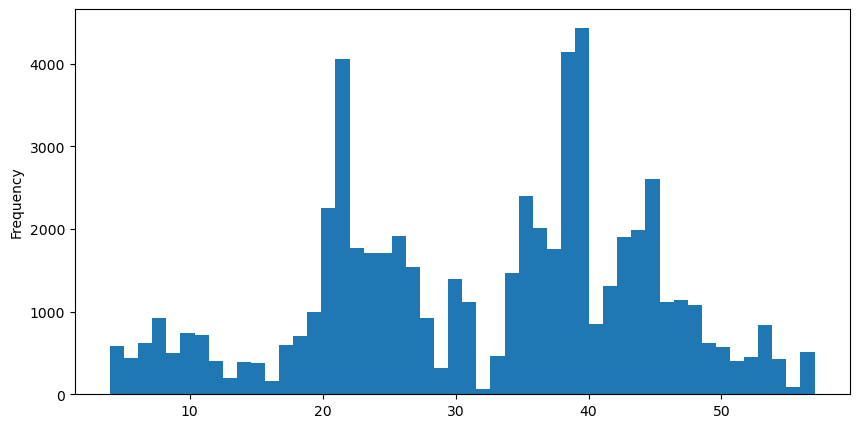

In [14]:
train_df['age'] = train_df['lease_commence_date'].apply(lambda x: 2023 - x)
train_df.drop(columns=['lease_commence_date'], inplace=True)
test_df['age'] = test_df['lease_commence_date'].apply(lambda x: 2023 - x)
test_df.drop(columns=['lease_commence_date'], inplace=True)
train_df['age'].plot(kind='hist', bins=50, figsize=(10, 5))

/Users/luchungi/opt/anaconda3/envs/cs5228/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


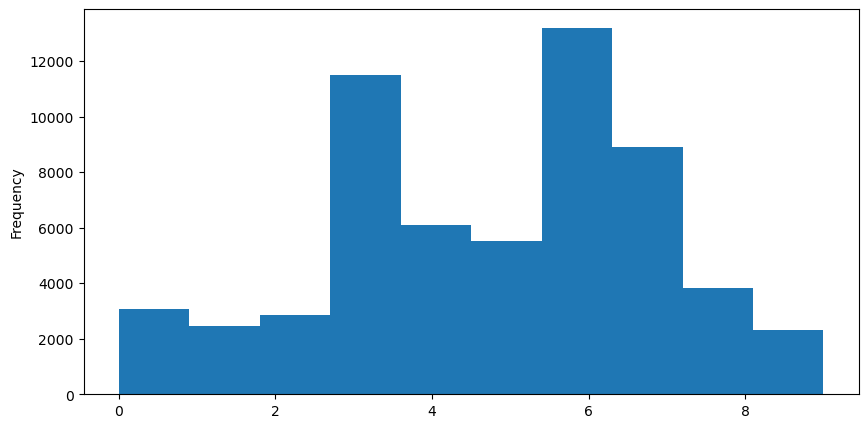

In [15]:
n_age_bins = 10
age_KBD = KBinsDiscretizer(n_bins=n_age_bins, encode='ordinal', strategy='uniform')
age_KBD.fit(train_df[['age']])
age_KBD.bin_edges_
train_df['age_bin'] = age_KBD.transform(train_df[['age']]).astype(int)
train_df['age_bin'].plot(kind='hist', bins=n_age_bins, figsize=(10, 5))
test_df['age_bin'] = age_KBD.transform(test_df[['age']]).astype(int)

# Proximity to malls

In [16]:
mall_df = pd.read_csv('./data/auxiliary-data/sg-shopping-malls.csv')
mall_df.head()

,name,latitude,longitude
0,100 AM,1.274588,103.843471
1,313@Somerset,1.301385,103.837684
2,Aperia,1.310867,103.863930
3,Balestier Hill Shopping Centre,1.325596,103.842572
4,Bugis Cube,1.298141,103.855635


In [17]:
# convert latitudes and longitudes to radians
mall_df['lat_rads'] = np.radians(mall_df['latitude'])
mall_df['long_rads'] = np.radians(mall_df['longitude'])
distance = haversine_distances(train_df[['lat_rads', 'long_rads']], mall_df[['lat_rads', 'long_rads']])
distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
train_df['shortest_dist_mall'] = distance.min(axis=1)
distance = haversine_distances(test_df[['lat_rads', 'long_rads']], mall_df[['lat_rads', 'long_rads']])
distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
test_df['shortest_dist_mall'] = distance.min(axis=1)
train_df

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,latitude,longitude,...,long_rads,num_top_sch_1km,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km,age,age_bin,shortest_dist_mall
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1.344518,103.738630,...,1.810581,1,1,0,2,2,4,40,6,1.202674
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1.330186,103.938717,...,1.814073,1,2,1,1,3,6,45,7,1.114338
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1.332242,103.845643,...,1.812448,1,4,0,1,1,3,52,9,0.468297
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1.370239,103.962894,...,1.814495,0,0,2,2,1,4,30,4,0.402359
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1.320502,103.863341,...,1.812757,1,1,0,1,1,2,51,8,1.073354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1.366050,103.854168,...,1.812597,0,0,1,3,4,6,44,7,0.949719
59996,2023-04,bukit merah,95a,henderson road,4-room,model a,83.0,yes,1.286493,103.821434,...,1.812026,0,0,1,4,2,4,4,0,0.740674
59997,2022-06,tampines,862a,tampines street 83,5-room,improved,122.0,yes,1.355064,103.936507,...,1.814034,2,3,0,2,2,5,35,5,0.439795
59998,2023-01,bedok,67,Bedok Sth Avenue 3,5-room,standard,123.0,yes,1.318974,103.944076,...,1.814166,1,2,0,0,1,3,46,7,1.775198


# Test prediction

In [32]:
x_col = ['town', 'flat_type', 'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km', 'age_bin', 'floor_area_sqm', 'shortest_dist_mall']
y_col = ['monthly_rent']

train_pool = Pool(train_df[x_col], train_df[y_col], cat_features=np.arange(9))
test_pool = Pool(test_df[x_col], cat_features=np.arange(9))

model = CatBoostRegressor(iterations=100,
                          depth=4,
                          learning_rate=1,
                          loss_function='RMSE')
# train the model
model.fit(train_pool, plot=True)
preds = model.predict(test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 602.5476602	total: 14.9ms	remaining: 1.47s
1:	learn: 581.9743506	total: 23.6ms	remaining: 1.15s
2:	learn: 573.6520184	total: 29.6ms	remaining: 957ms
3:	learn: 570.0770631	total: 37.8ms	remaining: 906ms
4:	learn: 568.8604031	total: 43.5ms	remaining: 826ms
5:	learn: 568.0903998	total: 49ms	remaining: 768ms
6:	learn: 567.8652177	total: 56.6ms	remaining: 752ms
7:	learn: 566.8180360	total: 62.2ms	remaining: 715ms
8:	learn: 566.0602883	total: 68.7ms	remaining: 695ms
9:	learn: 565.8968040	total: 74.6ms	remaining: 671ms
10:	learn: 565.5295553	total: 81ms	remaining: 656ms
11:	learn: 565.4648720	total: 87.1ms	remaining: 639ms
12:	learn: 564.7481950	total: 92.5ms	remaining: 619ms
13:	learn: 563.7528665	total: 97.8ms	remaining: 601ms
14:	learn: 563.3413895	total: 105ms	remaining: 594ms
15:	learn: 562.3429680	total: 110ms	remaining: 579ms
16:	learn: 561.8797441	total: 116ms	remaining: 569ms
17:	learn: 561.3753689	total: 123ms	remaining: 559ms
18:	learn: 560.7233422	total: 128ms	remaining: